# This notebook trains ULMFIT model [Finetunes and trains classification model] on the preprocessed data [see 2_PreProcessing notebook] in csv format [Relevant blogs: https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb, https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loading relevant libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

# Defining relevant metric for the model.
## Read https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/ for details 

In [3]:
@np_func
def f1_macro(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1),average='macro')

In [4]:
bs,bptt=128,30

# Check whether GPU is enabled or not. 
## Note: Some features of ULMFIT e.g. MixedPrecisionTraining won't work on cpu. Read https://forums.fast.ai/t/mixed-precision-training/20720 for more details. 

In [5]:
torch.cuda.set_device(0)
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'GeForce GTX 1070'

# Set data_path. 
## The directory structure has to be : data_path->frwiki->models. Make sure you have fwd and bwd Language models and vocabs in models folder.
### Download LM and vocab from link: https://console.aws.amazon.com/s3/buckets/natural-language-processing-models/French%2520Language%2520Models%2520-%2520ULMFit/?region=us-east-2&tab=overview

In [6]:
data_path = Path('/home/hsahi/HardikSahi/JupNotebook3.6/CPPFrench/Data')
lang='fr'
name = f'{lang}wiki'
path = data_path/name
mdl_path = path/'models'
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

# Load CSV data for training the model

In [7]:
csv_file_name = '3_PreProcessedFrenchData.csv'
fields = ['intent_english','source','preprocessed_french']
df = pd.read_csv(data_path/csv_file_name, delimiter='\t',encoding='utf-8', usecols=fields)
df.head()

,intent_english,source,preprocessed_french
0,change_plan,actual,ajouter plus à planifier
1,change_plan,actual,supplémentaire changements
2,change_plan,actual,Comment puis-je ajouter encore plus
3,change_plan,actual,il manque quelque chose dans ma police
4,change_plan,actual,tout autre régime?


In [9]:
## Read newly translated train data
new_csv_file_name = 'ExtraTranslated4TrainPreprocessed.csv'
new_df = pd.read_csv(data_path/new_csv_file_name, delimiter='\t',encoding='utf-8', usecols=fields)

In [10]:
df = pd.concat([df,new_df], sort=False)

# EDA on loaded data.

## Check and remove duplicate data points

In [11]:
print(f'number of entries:{len(df)}')
same = len(df) - len(df['preprocessed_french'].unique())
print(f'number of identical reviews: {same}')

number of entries:2266
number of identical reviews: 593


In [12]:
# Get rid of duplicates....
df.drop_duplicates(subset ="preprocessed_french", keep = "first", inplace = True)
same_removal = len(df) - len(df['preprocessed_french'].unique())
print(f'number of entries:{len(df)}')
print(f'number of identical reviews: {same_removal}')

number of entries:1673
number of identical reviews: 0


In [13]:
## Determine number of actual and synthetic data points....
intent_source_df = df.groupby(['intent_english', 'source']).size().reset_index(name='counts')

In [14]:
actual_intent_source_df = intent_source_df[intent_source_df['source']=='actual']
#synthetic_intent_source_df = intent_source_df[intent_source_df['source']=='synthetic']

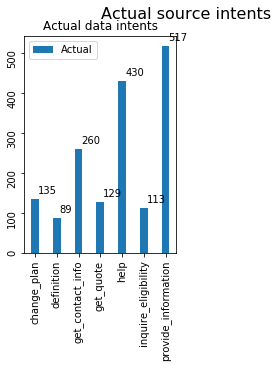

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
width=0.35
# synthetic_intent_names, synthetic_intent_count = synthetic_intent_source_df['intent_english'].values, synthetic_intent_source_df['counts'].values

# height_test = synthetic_intent_count
# bars_test = synthetic_intent_names
# y_pos_test = np.arange(len(bars_test))

# # Create bars
# rects1=ax1.bar(y_pos_test- width/2, height_test,width, tick_label=bars_test, label='Synthetic')

actual_cpp_intent_names, actual_cpp_intent_count = actual_intent_source_df['intent_english'].values, actual_intent_source_df['counts'].values

height = actual_cpp_intent_count
bars = actual_cpp_intent_names
y_pos = np.arange(len(bars))

# Create bars
rects2=ax1.bar(y_pos+ width/2, height, width,tick_label=bars, label='Actual')

ax1.tick_params(rotation=90)
ax1.set_title(r'Actual data intents')

ax1.legend()

fig.suptitle('Actual source intents', fontsize=16)

def autolabel(rects, axes,xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        axes.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

#autolabel(rects1,ax1, "left")
autolabel(rects2,ax1, "right")


# ax2 = fig.add_subplot(122)
# synthetic_intent_names, synthetic_intent_count = synthetic_intent_source_df['intent_english'].values, synthetic_intent_source_df['counts'].values

# ag_height = synthetic_intent_count
# ag_bars = synthetic_intent_names
# ag_y_pos = np.arange(len(ag_bars))


# # Create bars
# rects3=ax2.bar(ag_y_pos- width/2, ag_height,width, tick_label=ag_bars, label='Synthetic')


# ax2.tick_params(rotation=90)
# ax2.set_title(r'Synthetic source intents')


# ax2.legend()
# autolabel(rects3,ax2, "left")
fig.show()

# Make sure that both train and val have examples from all the intents

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
split_prct = 0.3

In [18]:
df_actual = df[df['source']=='actual']
#df_synthetic = df[df['source']=='synthetic']

In [19]:
df_actual_trn, df_actual_val = train_test_split(df_actual, stratify = df_actual['intent_english'], test_size = split_prct, random_state = 12)

In [20]:
print(len(df_actual_trn))
print(len(df_actual_val))

1171
502


In [21]:
#df_synthetic_trn, df_synthetic_val = train_test_split(df_synthetic, stratify = df_synthetic['intent_english'], test_size = 0.3, random_state = 12)

#print(len(df_synthetic_trn))
#print(len(df_synthetic_val))

#df_trn = pd.concat([df_actual_trn,df_synthetic_trn], sort=False)
#df_val = pd.concat([df_actual_val,df_synthetic_val], sort=False)

In [22]:
# Uncomment if only actual data is needed
df_trn = df_actual_trn
df_val = df_actual_val

In [23]:
# shuffling the entries..
df_trn = df_trn.sample(frac=1, random_state=42).reset_index(drop=True).drop(['source'], axis=1)
df_val = df_val.sample(frac=1, random_state=42).reset_index(drop=True).drop(['source'], axis=1)

In [24]:
print(f'Examples in train set:{len(df_trn)}')
print(f'Examples in val set:{len(df_val)}')

Examples in train set:1171
Examples in val set:502


In [25]:
train_intent_df = df_trn.groupby(['intent_english']).size().reset_index(name='counts')
val_intent_df = df_val.groupby(['intent_english']).size().reset_index(name='counts')

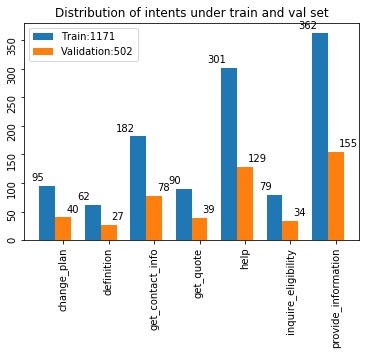

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
width=0.35
train_intent_names, train_intent_count = train_intent_df['intent_english'].values, train_intent_df['counts'].values

height_test = train_intent_count
bars_test = train_intent_names
y_pos_test = np.arange(len(bars_test))

# Create bars
rects1=ax1.bar(y_pos_test- width/2, height_test,width, tick_label=bars_test, label=f'Train:{len(df_trn)}')

val_intent_names, val_intent_count = val_intent_df['intent_english'].values, val_intent_df['counts'].values

height = val_intent_count
bars = val_intent_names
y_pos = np.arange(len(bars))

# Create bars
rects2=ax1.bar(y_pos+ width/2, height, width,tick_label=bars, label=f'Validation:{len(df_val)}')

ax1.tick_params(rotation=90)
ax1.set_title(r'Distribution of intents under train and val set')

ax1.legend()

def autolabel(rects, axes,xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        axes.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

autolabel(rects1,ax1, "left")
autolabel(rects2,ax1, "right")
fig.show()

## Step1: Load data for training ULMFIT model [Forward direction]

In [27]:
df_concat = pd.concat([df_trn,df_val], sort=False).sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
data_lm = (TextList.from_df(df_concat,path="",cols="preprocessed_french").split_by_rand_pct(0.1, seed=42).label_for_lm().databunch(bs=bs,num_workers=1))

In [29]:
data_lm.show_batch()

idx,text
0,"a diagnostiqué un risque médical de xxup nombre ans ? xxbos d'accord merci xxbos risque médical en xxup nombre xxbos poids ; xxup nombre xxbos xxmaj pouvez - vous me donner le numéro xxup nombre xxbos xxmaj ah merci , je vais envoyer un sms maintenant xxbos j'ai besoin d'aide à chercher un devis pour plusieurs options xxbos xxmaj comment chercher un devis pour assurance vie xxunk xxbos xxmaj xxunk"
1,"médical elle pèse xxup nombre livres et mesure xxup nombre , xxup nombre m. xxbos les xxunk xxunk besoin d'aide xxbos xxmaj mon client a xxunk quelques accessoires de fumeur pendant l'année dernière , est - il statut de fumeur xxbos xxunk xxbos xxmaj xxunk - vous de l'assurance maladies graves xxbos donnez - moi un prix pour type de police et type de police les deux xxbos xxmaj pas"
2,xxbos à quoi peut prétendre une personne atteinte de risque médical et qui a atteint l'âge de xxup nombre ans ? xxbos xxmaj pouvez - vous me contacter ? xxbos xxmaj changer le régime que j'ai actuellement xxbos xxmaj mon client a risque médical xxbos formulaire d'assurance - vie en xxunk pdf svp xxbos salut jusqu'à quelle heure êtes - vous ouverts ? xxbos xxmaj obtenir un numéro de téléphone
3,xxunk . xxbos bien sûr que pas xxbos en santé femme xxup nombre xxbos dernier xxup nombre mois xxbos autre aide xxbos quel est le prix pour quelqu'un qui fait de la xxunk xxunk et veux type de police xxup nombre ans xxup nombre xxbos absolument xxbos je cherche la formulaire pour demander une xxunk du capital type de personne sur une police xxbos xxmaj connecter avec vous xxbos xxmaj
4,"une risque médical elle pèse xxup nombre kg et mesure xxup nombre , xxup nombre m. xxbos xxmaj quelqu'un peut - il m'appeler s'il vous plaît à xxbos ou puis - je trouver le formulaire d'annulation xxbos xxmaj comment puis - je me mettre en contact avec vous ? xxbos xxmaj pas vraiment xxbos à quoi une personne traitée pour la trisomie xxup nombre et qui a atteint l'âge de"


In [30]:
#data_lm.save(f'{path}/fr_data_lm.pkl')

In [31]:
data_lm = load_data(path, 'fr_data_lm.pkl', bs=bs)

## Step2: Fine tune the language model using our data [Forward direction]. This section finetunes ULMFIT layers using Triangular slanting learning rates and Discriminative learning rates [https://yashuseth.blog/2018/06/17/understanding-universal-language-model-fine-tuning-ulmfit/, http://teleported.in/posts/cyclic-learning-rate/]

In [32]:
%%time
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0).to_fp16()

CPU times: user 301 ms, sys: 251 ms, total: 552 ms
Wall time: 1.88 s


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.32E-01


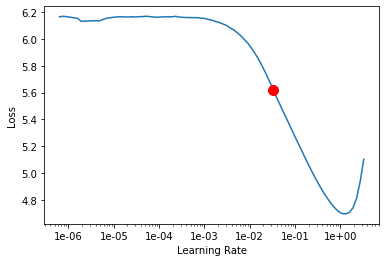

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [34]:
lr = 1e-2
lr *=bs/48

In [35]:
learn.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.965210,4.555396,0.262723,00:00
1,5.194104,3.569972,0.330134,00:00


In [36]:
learn.unfreeze()
learn.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.821125,3.088368,0.392746,00:00
1,3.959070,4.009554,0.325781,00:00
2,3.895043,2.940737,0.408371,00:00
3,3.636164,2.523194,0.471317,00:00
4,3.386004,2.347678,0.496875,00:00
5,3.202974,2.296528,0.501451,00:00
6,3.035501,2.257781,0.510491,00:00
7,2.917197,2.243371,0.510603,00:00


In [37]:
learn.save(f'{lang}fine_tuned')
learn.save_encoder(f'{lang}fine_tuned_enc')

In [38]:
len(data_lm.train_ds.vocab.itos)

488

## Step3: Fine tuning classifier [Forward direction]

In [39]:
bs = 128

In [40]:
data_lm = load_data(path, 'fr_data_lm.pkl', bs=bs)

In [41]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=bs, text_cols="preprocessed_french", label_cols="intent_english")

In [42]:
data_clas.show_batch()

text,target
"xxbos xxmaj bonjour , j'ai un problème avec la renonciation à mon assurance . xxmaj je suis dans la xxunk "" xxmaj informations pour xxunk "" de la renonciation et xxunk fois que xxunk de la soumettre , le "" nom de la type de personne se xxunk à "" aucune "" et un message xxunk xxunk : "" xxmaj vous xxunk remplir tous les xxunk "" .",help
"xxbos xxmaj bonjour , j'aimerais qu'on me rappelle le plus tôt possible . xxmaj j'ai xxunk deux formulaires de demande de devis et je n'ai reçu aucune xxunk . xxmaj je dois mettre en place mon assurance xxunk le plus tôt possible . xxmaj xxunk de xxmaj xxunk , xxup nombre - xxup nombre - xxup nombre . xxmaj je vous xxunk !",help
xxbos xxmaj je suis actuellement type de personne . xxmaj j'ai changé mes renseignements bancaires et mon adresse . xxmaj je dois résoudre ce problème car j'avais des xxunk sans xxunk dans mon xxunk xxunk . pouvez - vous s'il vous plaît m'appeler au xxup nombre - xxup nombre - xxup nombre - xxup nombre .,help
xxbos xxmaj je suis actuellement type de personne . xxmaj j'ai changé mes renseignements bancaires et mon adresse . xxmaj je dois résoudre ce problème car j'avais des xxunk sans xxunk dans mon xxunk xxunk . pouvez - vous s'il vous plaît m'appeler au xxup nombre - xxup nombre - xxup nombre - xxup nombre .,help
xxbos xxmaj quel serait le xxunk xxunk d'assurance xxunk pour une xxmaj xxunk xxmaj xxunk xxup nombre pour mon xxunk xxunk de xxup nombre ans ? xxmaj il a xxunk son permis de xxunk le xxup nombre xxunk de cette xxunk . xxmaj xxunk pour deux ans . xxmaj juste un xxunk xxunk serait bien .,get_quote


In [43]:
#%%time
#data_clas.save(f'{path}/fr_textlist_class.pkl')

### Step3a. Change the loss function to Focal Loss to handle imbalanced dataset [https://hackernoon.com/fast-ai-in-production-real-word-text-classification-with-ulmfit-199769be2a6], [https://www.youtube.com/watch?v=44tlnmmt3h0]

In [44]:
%%time
data_clas = load_data(path, 'fr_textlist_class.pkl', bs=bs, num_workers=1)

CPU times: user 68.8 ms, sys: 51 µs, total: 68.9 ms
Wall time: 130 ms


In [45]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, f1_macro]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
#learn_c.load_encoder(f'{lang}fine_tuned_enc');

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1171 items)
x: TextList
xxbos xxmaj quand est - ce que je xxunk à nom de compagnie,xxbos xxmaj puis - je obtenir une police d'assurance pour une xxunk de xxunk,xxbos aide maintenant,xxbos il n'y a pas plus,xxbos xxmaj j'ai besoin d'une nouvelle police qui me xxunk
y: CategoryList
help,get_quote,help,provide_information,change_plan
Path: .;

Valid: LabelList (502 items)
x: TextList
xxbos xxmaj oh merci , j'vais envoyer un texto maintenant,xxbos xxmaj aidez - moi , s'il vous plaît,xxbos xxmaj connecter avec votre xxunk maintenant,xxbos xxup svp me donner une cotation pour une personne de xxup nombre ans sans problème de santé,xxbos à quoi peut prétendre une personne qui a été traitée pour risque médical et a xxup nombre ans ?
y: CategoryList
get_contact_info,help,get_contact_info,inquire_eligibility,inquire_eligibility
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embeddi

In [46]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [48]:
# loss_weights = torch.FloatTensor(trn_weights).cuda()
# learn_c.loss_func = partial(F.cross_entropy, weight=loss_weights)

In [49]:
learn_c.loss_func = FocalLoss(gamma=2.0)

In [50]:
learn_c.loss_func

FocalLoss()

### Step 3b. Train the Forward model using Discriminative Fine Tuning, Traingular slanting learning rates and Gradual unfreezing of layers.

In [51]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 3.02E-02


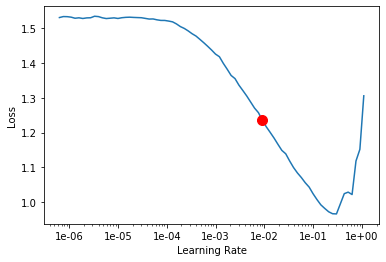

In [52]:
learn_c.lr_find()
learn_c.recorder.plot(suggestion=True)
min_grad_lr = learn_c.recorder.min_grad_lr

In [53]:
lr = 1e-2#min_grad_lr
lr *= bs/48

In [54]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.938542,0.858722,0.474104,0.236414,00:00
1,0.701699,0.685165,0.607570,0.318166,00:00


In [55]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.498894,0.585514,0.555777,0.408386,00:00
1,0.421687,0.430432,0.749004,0.558355,00:00


In [56]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.358455,0.372658,0.796813,0.638095,00:00
1,0.335296,0.312962,0.832669,0.711542,00:00


In [57]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.232640,0.270742,0.866534,0.733796,00:00
1,0.181021,0.245014,0.872510,0.755844,00:00


In [58]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.119927,0.228701,0.890438,0.771215,00:00


In [59]:
learn_c.save(f'{lang}clas')

## Step4: Load data for training ULMFIT model [Backward direction]

In [60]:
lm_fns_bwd = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

In [61]:
data_lm = (TextList.from_df(df_concat,path="",cols="preprocessed_french").split_by_rand_pct(0.1, seed=42).label_for_lm().databunch(bs=bs,num_workers=1, backwards=True))

In [62]:
data_lm.show_batch()

idx,text
0,"dernier xxunk nombre xxup était qui poids mon fournir veux je , nombre xxup de est taille , nombre xxup de est âge médical risque a fumeur de statut , homme xxbos d'assurance compagnies ajouter xxbos maintenant devis d'un besoin xxbos accès un aussi xxunk je et xxunk xxmaj personne de type un suis je xxmaj xxbos . nombre xxup pieds nombre xxup mesure et kg nombre xxup pèse elle"
1,coordonnées des obtenir xxmaj xxbos police la de reçu le télécharger pour xxunk un t'il - a - y xxbos xxunk votre de pdf fichier un sauvegarder à moi - aidez xxmaj xxbos nombre xxup sept nombre xxup xxbos ? ans nombre xxup a qui médical risque un xxunk soupçonnée personne une prétendre peut quoi à xxbos ? affaires xxunk de xxunk pour xxunk nombre xxup / nombre xxup xxunk
2,pouvez xxmaj xxbos xxunk pas xxbos ? normales heures les après texto un envoyer je - puis xxbos ? normales heures les après sms des envoyer vous je - puis xxbos nombre xxup pieds nombre xxup xxbos police la ajouter xxbos soumission une pour d'assurance montant le pas connais ne je xxmaj xxbos vie az à m'inscrire pour d'aide besoin j'ai xxbos site le accéder comment demande xxbos wfg xxup
3,xxbos ? xxunk prime son xxunk xxunk cliente qu'une pour xxunk électronique fonds de transfert de formulaire un vous - avez xxmaj xxbos ? xxunk affaires mes voir je - puis où xxmaj xxbos merci oui xxmaj xxbos xxunk pas xxunk tu xxbos ? texto un envoyer vous je - puis xxbos non que sûr bien xxbos ? passe de mot mon de pas souviens me ne je xxmaj xxbos
4,pour xxbos sûr bien ouais xxmaj xxbos personne de type capital xxmaj xxbos ? xxunk de lien le est où xxmaj xxbos vente de fiche une trouver comment xxbos non fumeur de statut est statut mon xxbos . nombre xxup pieds nombre xxup mesure et kg nombre xxup pèse elle . xxunk xxunk pour traitée est ans nombre xxup de âge elle xxbos ? xxunk vous peux je auquel numéro


In [ ]:
#data_lm.save(f'{path}/fr_data_lm_bwd.pkl')

In [63]:
data_lm = load_data(path, 'fr_data_lm_bwd.pkl', bs=bs,backwards=True)

## Step5: Fine tune the language model using our data [Backward direction]. This section finetunes ULMFIT layers using Triangular slanting learning rates and Discriminative learning rates [https://yashuseth.blog/2018/06/17/understanding-universal-language-model-fine-tuning-ulmfit/, http://teleported.in/posts/cyclic-learning-rate/]

In [64]:
%%time
learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152}, pretrained_fnames=lm_fns_bwd, drop_mult=1.0).to_fp16()

CPU times: user 137 ms, sys: 284 ms, total: 421 ms
Wall time: 1.3 s


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.58E-01


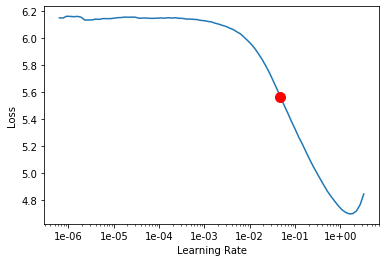

In [65]:
learn_lm.lr_find()
learn_lm.recorder.plot(suggestion=True)
min_grad_lr = learn_lm.recorder.min_grad_lr

In [66]:
lr = 1e-2
lr *= bs/48

In [67]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.971511,4.834075,0.270424,00:00
1,5.237400,3.704389,0.377344,00:00


In [68]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.730409,3.119571,0.415960,00:00
1,3.475434,2.630818,0.454688,00:00
2,3.175295,2.297700,0.476897,00:00
3,2.924695,2.126381,0.514509,00:00
4,2.720818,2.079745,0.515402,00:00
5,2.554128,2.061364,0.521875,00:00
6,2.423579,2.047645,0.526116,00:00
7,2.321327,2.039715,0.526897,00:00


In [69]:
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')

## Step6: Fine tuning classifier [Backward direction]

In [70]:
bs = 128

In [71]:
data_lm = load_data(path, 'fr_data_lm_bwd.pkl', bs=bs, backwards=True)

In [72]:
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=bs, text_cols="preprocessed_french", label_cols="intent_english", backwards=True)

In [73]:
%%time
data_clas.save(f'{path}/fr_textlist_class_bwd.pkl')

CPU times: user 17.3 ms, sys: 4.34 ms, total: 21.6 ms
Wall time: 21.3 ms


### Step6a. Change the loss function to Focal Loss to handle imbalanced dataset [https://hackernoon.com/fast-ai-in-production-real-word-text-classification-with-ulmfit-199769be2a6], [https://www.youtube.com/watch?v=44tlnmmt3h0]

In [74]:
%%time
data_clas = load_data(path, 'fr_textlist_class_bwd.pkl', bs=bs, num_workers=1, backwards=True)

CPU times: user 22.9 ms, sys: 6.59 ms, total: 29.5 ms
Wall time: 29.1 ms


In [75]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1_macro]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1171 items)
x: TextList
xxbos xxmaj quand est - ce que je xxunk à nom de compagnie,xxbos xxmaj puis - je obtenir une police d'assurance pour une xxunk de xxunk,xxbos aide maintenant,xxbos il n'y a pas plus,xxbos xxmaj j'ai besoin d'une nouvelle police qui me xxunk
y: CategoryList
help,get_quote,help,provide_information,change_plan
Path: .;

Valid: LabelList (502 items)
x: TextList
xxbos xxmaj oh merci , j'vais envoyer un texto maintenant,xxbos xxmaj aidez - moi , s'il vous plaît,xxbos xxmaj connecter avec votre xxunk maintenant,xxbos xxup svp me donner une cotation pour une personne de xxup nombre ans sans problème de santé,xxbos à quoi peut prétendre une personne qui a été traitée pour risque médical et a xxup nombre ans ?
y: CategoryList
get_contact_info,help,get_contact_info,inquire_eligibility,inquire_eligibility
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embeddi

In [76]:
learn_c.loss_func = FocalLoss(gamma=2.0)

In [77]:
learn_c.loss_func

FocalLoss()

### Step 6b. Train the Forward model using Discriminative Fine Tuning, Traingular slanting learning rates and Gradual unfreezing of layers.

In [78]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.63E-02


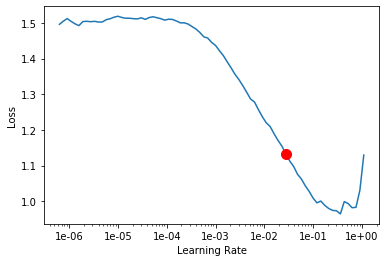

In [79]:
learn_c.lr_find()
learn_c.recorder.plot(suggestion=True)
min_grad_lr = learn_c.recorder.min_grad_lr

In [80]:
lr = 1e-2#min_grad_lr
lr *= bs/48

In [81]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.989181,0.910581,0.533865,0.212978,00:00
1,0.708170,0.867307,0.517928,0.192535,00:00


In [82]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.493186,0.566058,0.683267,0.434071,00:00
1,0.419084,0.468325,0.725100,0.569596,00:00


In [83]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.233640,0.295560,0.848606,0.698990,00:00
1,0.206031,0.234766,0.876494,0.738494,00:00


In [84]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1_macro,time
0,0.140332,0.236249,0.886454,0.744267,00:00


In [85]:
learn_c.save(f'{lang}clas_bwd')

# Confusion matrix on Validation set


In [86]:
%%time
data_clas_fwd = load_data(path, f'{lang}_textlist_class.pkl', bs=bs, num_workers=1)

learn_c_fwd = text_classifier_learner(data_clas_fwd, AWD_LSTM, drop_mult=0.5, 
                                  metrics=[accuracy, f1_macro]).to_fp16()

learn_c_fwd.load(f'{lang}clas', purge=False);
#learn_c_fwd.loss_func = FocalLoss(gamma=2.0)

CPU times: user 263 ms, sys: 109 ms, total: 373 ms
Wall time: 371 ms


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1171 items)
x: TextList
xxbos xxmaj quand est - ce que je xxunk à nom de compagnie,xxbos xxmaj puis - je obtenir une police d'assurance pour une xxunk de xxunk,xxbos aide maintenant,xxbos il n'y a pas plus,xxbos xxmaj j'ai besoin d'une nouvelle police qui me xxunk
y: CategoryList
help,get_quote,help,provide_information,change_plan
Path: .;

Valid: LabelList (502 items)
x: TextList
xxbos xxmaj oh merci , j'vais envoyer un texto maintenant,xxbos xxmaj aidez - moi , s'il vous plaît,xxbos xxmaj connecter avec votre xxunk maintenant,xxbos xxup svp me donner une cotation pour une personne de xxup nombre ans sans problème de santé,xxbos à quoi peut prétendre une personne qui a été traitée pour risque médical et a xxup nombre ans ?
y: CategoryList
get_contact_info,help,get_contact_info,inquire_eligibility,inquire_eligibility
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embeddi

In [87]:
# Export forward model so that it can be used for inference in Pronav pipeline [To be done only once]
learn_c_fwd.export(file="export_class_fwd.pkl")

In [88]:
#learn_c_fwd.model
#learn_c_fwd.model.state_dict()

In [89]:
# Predictions on val data using forward model
preds_fwd,targs_fwd, losses_fwd = learn_c_fwd.get_preds(ordered=True, with_loss=True)
accuracy(preds_fwd,targs_fwd),f1_macro(preds_fwd,targs_fwd)

(tensor(0.8904), tensor(0.8660))

In [90]:
%%time
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd.pkl', bs=bs, num_workers=1,backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, 
                                  metrics=[accuracy, f1_macro]).to_fp16()

learn_c_bwd.load(f'{lang}clas_bwd', purge=False);

CPU times: user 286 ms, sys: 80.7 ms, total: 367 ms
Wall time: 366 ms


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1171 items)
x: TextList
xxbos xxmaj quand est - ce que je xxunk à nom de compagnie,xxbos xxmaj puis - je obtenir une police d'assurance pour une xxunk de xxunk,xxbos aide maintenant,xxbos il n'y a pas plus,xxbos xxmaj j'ai besoin d'une nouvelle police qui me xxunk
y: CategoryList
help,get_quote,help,provide_information,change_plan
Path: .;

Valid: LabelList (502 items)
x: TextList
xxbos xxmaj oh merci , j'vais envoyer un texto maintenant,xxbos xxmaj aidez - moi , s'il vous plaît,xxbos xxmaj connecter avec votre xxunk maintenant,xxbos xxup svp me donner une cotation pour une personne de xxup nombre ans sans problème de santé,xxbos à quoi peut prétendre une personne qui a été traitée pour risque médical et a xxup nombre ans ?
y: CategoryList
get_contact_info,help,get_contact_info,inquire_eligibility,inquire_eligibility
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embeddi

In [91]:
# Export backward model so that it can be used for inference in Pronav pipeline [To be done only once]
learn_c_bwd.export(file="export_class_bwd.pkl")

In [92]:
# Predictions on val data using backward model
preds_b,targs_b,losses_bwd = learn_c_bwd.get_preds(ordered=True, with_loss=True)
accuracy(preds_b,targs_b),f1_macro(preds_b,targs_b)

(tensor(0.8865), tensor(0.8628))

In [93]:
preds_avg = (preds_fwd+preds_b)/2

In [94]:
accuracy(preds_avg,targs_b),f1_macro(preds_avg,targs_b)

(tensor(0.8984), tensor(0.8727))

In [95]:
predictions = np.argmax(preds_avg, axis = 1)

In [96]:
#learn_c.show_results()

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [98]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 35   0   0   1   4   0   0]
 [  0  18   0   0   5   0   4]
 [  0   0  72   0   6   0   0]
 [  0   0   0  30   9   0   0]
 [  0   2   4   4 118   0   1]
 [  1   0   0   0   5  28   0]
 [  0   1   1   1   1   1 150]]


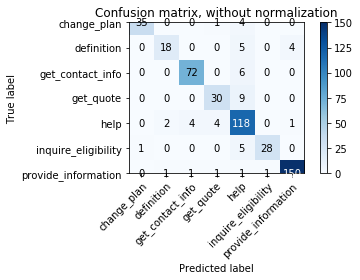

In [99]:
plot_confusion_matrix(np.array(targs_b), np.array(predictions), classes=learn_c_bwd.data.classes,
                      title='Confusion matrix, without normalization')

In [100]:
cm = confusion_matrix(np.array(targs_b), np.array(predictions))

recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [101]:
print(recall)
print(precision)

[0.875    0.666667 0.923077 0.769231 0.914729 0.823529 0.967742]
[0.972222 0.857143 0.935065 0.833333 0.797297 0.965517 0.967742]
